In [560]:
import pandas as pd
import numpy as np
import os
import re
import pickle
from bs4 import BeautifulSoup as soup
import requests as rq
import time
import h5py
import scipy as sp
import scipy.stats
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sn

# EDA

## Pulling in Data

The data collected is a mix of HDF5, csv and web scraped data about the Bay area.  The CSVs are for particle concentraions, HDF5s for CO2 ppm, and the web scraped data is for empty lot/apartments for sale in the San Fransisco.

In [814]:
#starting off by reading in the csv files
aqcsvs = []
aqcsvs += ['../../../../Documents/largecsvs/others/'+each for each in os.listdir('../../../../Documents/largecsvs/others/') if each.endswith('.csv')]

nc = []
nc += ['../../../../Documents/largecsvs/data/'+each for each in os.listdir('../../../../Documents/largecsvs/data/') if each.endswith('.nc')]

part = []
part += ['../../../../Documents/largecsvs/particle/'+each for each in os.listdir('../../../../Documents/largecsvs/particle/') if each.endswith('csv')]
#getting all H5 files for the project
results = []
results += ['../../../../Downloads/'+each for each in os.listdir('../../../../Downloads/') if each.endswith('.h5')]

In [933]:
# sorting CSVs so the are appended in order of oldest to most recent
aqcsvs=sorted(aqcsvs)
part=sorted(part)

In [325]:
#pulling in weather data from  
weatherdf = pd.read_csv('weather/1367384.csv')

In [326]:
#dropping unnecessary columns and filling NaNs
weatherdf.drop(['STATION', 'NAME','ELEVATION', 'SNWD', 'TOBS'], axis=1, inplace=True)
weatherdf = weatherdf.fillna(0)

In [327]:
weatherdf.head()

LATITUDE  LONGITUDE        DATE  PRCP  SNOW  TAVG  TMAX  TMIN
0   37.7705  -122.4269  2014-01-01   0.0   0.0   0.0  63.0  44.0
1   37.7705  -122.4269  2014-01-02   0.0   0.0   0.0  63.0  48.0
2   37.7705  -122.4269  2014-01-03   0.0   0.0   0.0  64.0  49.0
3   37.7705  -122.4269  2014-01-04   0.0   0.0   0.0  66.0  46.0
4   37.7705  -122.4269  2014-01-05   0.0   0.0   0.0  66.0  48.0

In [821]:
nc[0]

'../../../../Documents/largecsvs/data/co2_wgc_surface-pfp_1_allvalid.nc'

In [862]:
#reading in .nc files from the file paths seen above
from netCDF4 import Dataset
inland = Dataset(nc[0])
sfco2 = Dataset(nc[1])

In [826]:
inland.dimensions.keys()

odict_keys(['obs', 'calendar_components', 'string_of_100chars'])

In [827]:
inland.variables.keys()

odict_keys(['time', 'time_decimal', 'time_components', 'solartime_components', 'value', 'latitude', 'longitude', 'altitude', 'obs_flag', 'obspack_id', 'model_enkf_flag', 'model_hqhr', 'model_r', 'model_bg', 'model_ff', 'model_ocean', 'model_bio', 'model_fires', 'assimilated', 'u', 'v', 'blh', 'q', 'temperature', 'pressure'])

In [846]:
var = inland.variables['time'].units

In [927]:
#function to pull all the CO2 data from the nc files
def CO2df(nc):
    CO2time = []
    for y in np.array(nc.variables['time_components']):
        q= [str(x) for x in y]
        dt = pd.to_datetime(q[0]+'/'+q[1]+'/'+q[2])
        CO2time.append(dt)   
    latlong = [(x,y) for x,y in zip(np.array(nc.variables['latitude']),np.array(nc.variables['longitude']))]
    values = [x*10**6 for x in np.array(nc.variables['value'])]
    carbondf = pd.DataFrame({'Date':CO2time,
                             'latlong':latlong,
                             'CO2 ppm':values})
    return carbondf

In [928]:
#carbondf is the CO2 from inland california near sacramento, sfcdf is CO@ in San Fransisco 
carbondf = CO2df(inland)
sfcdf = CO2df(sfco2) 


In [929]:
carbondf

CO2 ppm       Date              latlong
0     390.550005 2007-09-21     (38.26, -121.48)
1     393.650000 2007-09-22     (38.26, -121.49)
2     387.870008 2007-09-22     (38.26, -121.48)
3     379.339996 2007-09-23     (38.26, -121.49)
4     383.779989 2007-09-24     (38.26, -121.48)
5     384.710002 2007-09-24     (38.26, -121.49)
6     388.179993 2007-09-25     (38.26, -121.48)
7     385.040010 2007-09-26     (38.26, -121.48)
8     387.550012 2007-09-27     (38.26, -121.48)
9     381.660007 2007-09-28     (38.26, -121.49)
10    383.239996 2007-09-30     (38.26, -121.49)
11    383.259990 2007-10-01     (38.26, -121.48)
12    381.399994 2007-10-02     (38.26, -121.48)
13    382.019993 2007-10-02     (38.26, -121.48)
14    384.279992 2007-10-03     (38.26, -121.48)
15    380.399986 2007-10-04     (38.26, -121.48)
16    381.769991 2007-10-05     (38.26, -121.48)
17    382.210012 2007-10-05     (38.26, -121.48)
18    381.349993 2007-10-06     (38.26, -121.48)
19    387.800013 2007-10-08     (38.26, -121.49)
20    387.750013 2007-10-08     (38.26, -121.49)
21    384.599989 2007-10-09     (38.26, -121.49)
22    384.649989 2007-10-09     (38.26, -121.49)
23    386.069994 2007-10-10     (38.26, -121.49)
24    385.919993 2007-10-10     (38.26, -121.49)
25    390.419998 2007-10-11     (38.26, -121.49)
26    389.780005 2007-10-11     (38.26, -121.49)
27    395.960000 2007-10-12     (38.26, -121.49)
28    389.469991 2007-10-13     (38.26, -121.49)
29    408.589985 2007-10-14     (38.26, -121.49)
...          ...        ...                  ...
2560  429.590000 2016-11-22  (38.265, -121.4911)
2561  420.760014 2016-11-24  (38.265, -121.4911)
2562  416.610012 2016-11-26  (38.265, -121.4911)
2563  412.399997 2016-11-28  (38.265, -121.4911)
2564  412.269990 2016-11-28  (38.265, -121.4911)
2565  429.679989 2016-11-30  (38.265, -121.4911)
2566  409.019995 2016-12-02  (38.265, -121.4911)
2567  406.990002 2016-12-06  (38.265, -121.4911)
2568  416.289986 2016-12-08  (38.265, -121.4911)
2569  420.780008 2016-12-10  (38.265, -121.4911)
2570  449.229992 2016-12-14  (38.265, -121.4911)
2571  449.359999 2016-12-14  (38.265, -121.4911)
2572  409.669999 2016-12-16  (38.265, -121.4911)
2573  413.530011 2016-12-18  (38.265, -121.4911)
2574  412.269990 2017-01-05  (38.265, -121.4911)
2575  413.089991 2017-01-07  (38.265, -121.4911)
2576  411.079993 2017-01-09  (38.265, -121.4911)
2577  408.419990 2017-01-11  (38.265, -121.4911)
2578  408.440013 2017-01-11  (38.265, -121.4911)
2579  411.610003 2017-01-13  (38.265, -121.4911)
2580  420.819997 2017-01-15  (38.265, -121.4911)
2581  411.779998 2017-02-02  (38.265, -121.4911)
2582  408.680004 2017-02-04  (38.265, -121.4911)
2583  408.910011 2017-02-06  (38.265, -121.4911)
2584  422.229990 2017-02-08  (38.265, -121.4911)
2585  422.259996 2017-02-08  (38.265, -121.4911)
2586  408.469990 2017-02-10  (38.265, -121.4911)
2587  422.979996 2017-02-12  (38.265, -121.4911)
2588  410.359993 2017-03-26  (38.265, -121.4911)
2589  409.639993 2017-03-28  (38.265, -121.4911)

[2590 rows x 3 columns]

In [841]:
inlandf.variables['value'].ncattrs()

['units', '_FillValue', 'long_name', 'comment']

In [486]:
#Reading particle data and assigning is to dataframe pdf
pdf=pd.read_csv(part[0])

for i in range(1,len(part)):
    temp = pd.read_csv(part[i])
    pdf = pd.concat([pdf,temp], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [487]:
#Filtering out unneed data from particle DF
pdf = pdf[pdf['State Name']=='California']
pdf = pdf[pdf['CBSA Name']=='San Francisco-Oakland-Hayward, CA']
pdf = pdf[pdf['City Name'].isin(['Oakland','Richmond','San Pablo','San Francisco','San Rafael'])]
pdf.drop(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Datum', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name','City Name',
       'CBSA Name', 'Date of Last Change'], axis=1, inplace=True)

pdf.reset_index(drop=True,inplace=True)

In [935]:
pdf

Latitude   Longitude               Param Name4  Date Local  Part Mean  \
0      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-01  24.958333   
1      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-02  18.041667   
2      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-03  18.166667   
3      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-04  15.958333   
4      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-05   8.416667   
5      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-06  26.958333   
6      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-07  29.791667   
7      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-08   6.708333   
8      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-09   7.217391   
9      37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-10  10.458333   
10     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-11  10.958333   
11     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-12   7.791667   
12     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-13   4.541667   
13     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-14   9.291667   
14     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-15  10.875000   
15     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-16  10.750000   
16     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-17  20.541667   
17     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-18  18.000000   
18     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-19  23.625000   
19     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-20  21.666667   
20     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-21  11.875000   
21     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-22  12.375000   
22     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-23  24.695652   
23     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-24  37.625000   
24     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-25  17.666667   
25     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-26  14.208333   
26     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-27  12.125000   
27     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-28   9.083333   
28     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-29   5.333333   
29     37.743065 -122.169935  PM2.5 - Local Conditions  2014-01-30   4.541667   
...          ...         ...                       ...         ...        ...   
17681  37.765946 -122.399044  PM2.5 - Local Conditions  2018-01-27   7.400000   
17682  37.765946 -122.399044  PM2.5 - Local Conditions  2018-01-28   5.000000   
17683  37.765946 -122.399044  PM2.5 - Local Conditions  2018-01-29  17.000000   
17684  37.765946 -122.399044  PM2.5 - Local Conditions  2018-01-30  13.100000   
17685  37.765946 -122.399044  PM2.5 - Local Conditions  2018-01-31  17.100000   
17686  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-01  13.800000   
17687  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-02  13.000000   
17688  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-03  12.400000   
17689  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-04  11.000000   
17690  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-05  16.100000   
17691  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-06   7.600000   
17692  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-07  15.500000   
17693  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-08  26.700000   
17694  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-09  15.600000   
17695  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-10   9.000000   
17696  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-11   8.600000   
17697  37.765946 -122.399044  PM2.5 - Local Conditions  2018-02-12   5.500000   
17698  37.765946 -122.399044  PM2.5 - L

In [936]:
aqcsvs

['../../../../Documents/largecsvs/others/COdaily_42101_2014.csv',
 '../../../../Documents/largecsvs/others/COdaily_42101_2015.csv',
 '../../../../Documents/largecsvs/others/COdaily_42101_2016.csv',
 '../../../../Documents/largecsvs/others/COdaily_42101_2017.csv',
 '../../../../Documents/largecsvs/others/COdaily_42101_2018.csv',
 '../../../../Documents/largecsvs/others/Odaily_44201_2014.csv',
 '../../../../Documents/largecsvs/others/Odaily_44201_2015.csv',
 '../../../../Documents/largecsvs/others/Odaily_44201_2016.csv',
 '../../../../Documents/largecsvs/others/Odaily_44201_2017.csv',
 '../../../../Documents/largecsvs/others/Odaily_44201_2018.csv',
 '../../../../Documents/largecsvs/others/SOdaily_42401_2014.csv',
 '../../../../Documents/largecsvs/others/SOdaily_42401_2015.csv',
 '../../../../Documents/largecsvs/others/SOdaily_42401_2016.csv',
 '../../../../Documents/largecsvs/others/SOdaily_42401_2017.csv',
 '../../../../Documents/largecsvs/others/SOdaily_42401_2018.csv',
 '../../../../D

In [953]:
#Creating a 3 dataframes based on which ones I will need, 2 are needed from this call
aq=pd.read_csv(aqcsvs[0])

for i in range(1,len(aqcsvs)):
    if i==15:
        aq2=pd.read_csv(aqcsvs[i])
    elif i>15 and i<=20:
        temp = pd.read_csv(aqcsvs[i])
        aq2 = pd.concat([aq2,temp], ignore_index=True)
    elif i==21:
        aq3=pd.read_csv(aqcsvs[i])
    elif i>21:
        temp = pd.read_csv(aqcsvs[i])
        aq3 = pd.concat([aq3,temp], ignore_index=True)
    else:
        temp = pd.read_csv(aqcsvs[i])
        aq = pd.concat([aq,temp], ignore_index=True)

In [965]:
#Filtering out unneed data
aq = aq[aq['State Name']=='California']
aq = aq[aq['CBSA Name']=='San Francisco-Oakland-Hayward, CA']
aq = aq[aq['City Name'].isin(['Oakland','Richmond','San Pablo','San Francisco','San Rafael'])]
aq.drop(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Datum', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name','City Name',
       'CBSA Name', 'Date of Last Change'], axis=1, inplace=True)
#filtering to relevant cities
aq.reset_index(drop=True,inplace=True)

KeyError: 'State Name'

In [959]:
codf = aq[aq['Parameter Name']=='Carbon monoxide'].copy()
ozdf= aq[aq['Parameter Name']=='Ozone'].copy()
sodf= aq[aq['Parameter Name']=='Sulfur dioxide'].copy()



In [960]:
ozdf.drop(['Latitude','Longitude'], axis=1, inplace=True)
sodf.drop(['Latitude','Longitude'], axis=1, inplace=True)
pdf.drop(['Latitude','Longitude'], axis=1, inplace=True)

ValueError: labels ['Latitude' 'Longitude'] not contained in axis

In [966]:
aq3 = aq3[['county Name', 'Date', 'AQI','Category', 'Defining Parameter']]
aq3.columns

Index(['county Name', 'Date', 'AQI', 'Category', 'Defining Parameter'], dtype='object')

In [970]:
#Filtering out unneed data
aq3 = aq3[aq3['county Name'].isin(aq['County Name'].unique())]
#filtering to relevant cities
aq3.reset_index(drop=True,inplace=True)
aq3.head()

county Name        Date  AQI                        Category  \
0     Alameda  2014-01-01  109  Unhealthy for Sensitive Groups   
1     Alameda  2014-01-02   80                        Moderate   
2     Alameda  2014-01-03   80                        Moderate   
3     Alameda  2014-01-04   67                        Moderate   
4     Alameda  2014-01-05   56                        Moderate   

  Defining Parameter  
0              PM2.5  
1              PM2.5  
2              PM2.5  
3              PM2.5  
4              PM2.5

In [971]:
codf.columns=['Latitude', 'Longitude', 'Param Name', 'Date Local',
              'CO Mean', 'CO Max Value', 'CO Max Hour','County Name']
ozdf.columns=['Param Name2', 'Date Local','Oz Mean', 'Oz Max Value', 'Oz Max Hour','County Name']
sodf.columns=['Param Name3', 'Date Local','SO Mean', 'SO Max Value', 'SO Max Hour','County Name']
aq3.columns=['County Name', 'Date Local', 'AQI', 'Category', 'AQ Defining Parameter']
pdf.columns =['Param Name4', 'Date Local','Part Mean', 'Part Max Value', 'Part Max Hour','County Name']


In [ ]:
aq = pd.merge(codf,ozdf, how='left',on=['Date Local','County Name'])
aq2 = pd.merge(aq,sodf, how='left',on=['Date Local','County Name'])
qq = pd.merge(aq2,qq, how='left', on=['Date Local','County Name'])
aq = pd.merge(qq,aq3, how='left',on=['Date Local','County Name'])

In [ ]:
aq.head()

In [547]:
aq['Date Local'] = pd.to_datetime(aq['Date Local'])

In [548]:
aq['Date Local'] =[x.date() for x in aq['Date Local']]

In [511]:
aq.drop(['Param Name', 'County Name', 'Param Name2','Param Name3','Param Name4'], axis=1, inplace = True)

In [931]:
aq.head()

Latitude   Longitude  Date Local   CO Mean  CO Max Value  CO Max Hour  \
72  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
73  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
74  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
75  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
76  37.814781 -122.282347  2015-01-10  0.579167           1.0            5   

     Oz Mean  Oz Max Value  Oz Max Hour   SO Mean  SO Max Value  SO Max Hour  \
72  0.008118         0.016            9  0.913636           2.4           15   
73  0.008118         0.016            9  0.913636           2.4           15   
74  0.008118         0.016            9  0.866667           1.4           14   
75  0.008118         0.016            9  0.866667           1.4           14   
76  0.008118         0.016            9  0.913636           2.4           15   

    Part Mean  Part Max Value  Part Max Hour  AQI  Category  \
72  17.458333            25.0              2   72  Moderate   
73  17.400000            17.4              0   72  Moderate   
74  17.458333            25.0              2   72  Moderate   
75  17.400000            17.4              0   72  Moderate   
76  17.458333            25.0              2   72  Moderate   

   AQ Defining Parameter  
72                 PM2.5  
73                 PM2.5  
74                 PM2.5  
75                 PM2.5  
76                 PM2.5

In [550]:
"""#Writing a pickle file to save data
import pickle
with open('climate_data.pkl', 'wb') as picklefile:
    pickle.dump(aq, picklefile)"""

In [684]:
def h5ToDF(file):
    f = h5py.File(file, 'r')
    date = [pd.to_datetime(str(x).replace('b\'','').replace('\'','')) for x in list(f['RetrievalHeader']['retrieval_time_string'])]
    lat = [x for x in list(f['RetrievalGeometry']['retrieval_latitude_geoid'])]
    long = [y for y in list(f['RetrievalGeometry']['retrieval_longitude_geoid'])]
    co2ppm = list(f['RetrievalResults']['xco2'])
    co2_uncert = [x*10**6 for x in list(f['RetrievalResults']['xco2_uncert'])]
    df = pd.DataFrame({'date':date,
        'lat':lat,
        'long': long,
        'co2ppm': co2ppm,
        'co2_uncert': co2_uncert
    })
    return df
                                                                                    
                                                                                    
                                                                                    

In [789]:
f = h5py.File(results[0], 'r')
date = [pd.to_datetime(str(x).replace('b\'','').replace('\'','')) for x in list(f['RetrievalHeader']['retrieval_time_string'])]
lat = [x for x in list(f['RetrievalGeometry']['retrieval_latitude_geoid'])]
long = [y for y in list(f['RetrievalGeometry']['retrieval_longitude_geoid'])]
co2ppm = list(f['RetrievalResults']['xco2'])
co2_uncert = [x*10**6 for x in list(f['RetrievalResults']['xco2_uncert'])]
df = pd.DataFrame({'date':date,
        'lat':lat,
        'long': long,
        'co2ppm': co2ppm,
        'co2_uncert': co2_uncert
    })
for i in range(1,int(len(results))):
    df.append(h5ToDF(results[i]))

In [790]:
len(results)

146

In [24]:
df['co2ppm'] = [x*10**6 for x in df['co2ppm']]

In [28]:
df['co2_uncert'] = [float(x) for x in df['co2_uncert']]

In [542]:
df['date'] = [x.date() for x in df['date']]

In [791]:
newdf = df[(df['lat']>37)&(df['lat']<38)].head()

In [792]:
newdf[newdf['long']<-122]

Empty DataFrame
Columns: [co2_uncert, co2ppm, date, lat, long]
Index: []

In [793]:
newdf

Empty DataFrame
Columns: [co2_uncert, co2ppm, date, lat, long]
Index: []

In [794]:
min(df['long'])

-114.09626007080078

In [551]:
"""#Writing a pickle file to save data
import pickle
with open('my_data.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)"""

In [529]:
#reading in the list of tea dictionaries, each being by itself
with open('my_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [ ]:
#list(f['RetrievalGeometry']['retrieval_latitude_geoid'])

## Web Scraping

Pulling data from loopnet.com for areas where we can greenify citys (make them more environmentally friendly). 

In [97]:
#initializing sites that I will pull from
flexspace = 'http://www.loopnet.com/california/san-francisco_flex-space-for-sale/'
land = 'http://www.loopnet.com/california/san-francisco_land-for-sale/'
apts = 'http://www.loopnet.com/california/san-francisco_apartment-buildings-for-sale/'

In [98]:
response = rq.get(land)
page = response.text
reviewp = soup(page,"lxml")


In [99]:
reviewp.find_all(class_='listingTitle')

[<span class="listingTitle">0.05 Acre Site for Proposed Apartments</span>,
 <span class="listingTitle">1228 Folsom Street</span>,
 <span class="listingTitle">1876 Oakdale Ave</span>,
 <span class="listingTitle">1791 Mission Street</span>,
 <span class="listingTitle">240 7th St</span>,
 <span class="listingTitle">1924 Mission St</span>,
 <span class="listingTitle">2435-2445 16th St</span>,
 <span class="listingTitle">Topaz Way</span>,
 <span class="listingTitle">Portfolio of 4 Properties</span>,
 <span class="listingTitle">1234 Shoreline Hwy</span>,
 <span class="listingTitle">81 Ervine St</span>,
 <span class="listingTitle">OCTAVIA M+N</span>,
 <span class="listingTitle">250 Church St</span>,
 <span class="listingTitle">Mission and 22nd</span>]

## Exploring

Exploring the data, kicking out points that are wrong based on the error and other stats.

In [654]:
#pulling in CO2 data
with open('my_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [553]:
#pulling in climate data
with open('climate_data.pkl', 'rb') as picklefile:
    aq = pickle.load(picklefile)

In [554]:
df.head()

co2_uncert      co2ppm        date                 latlong
0    0.886318  402.186939  2016-11-13   (-83.56647, 38.90449)
1    0.786782  398.468226  2016-11-13  (-83.59027, 39.013676)
2    0.780767  396.430114  2016-11-13   (-83.61452, 39.12222)
3    0.777430  398.074626  2016-11-13  (-83.46712, 38.238407)
4    0.799400  399.525161  2016-11-13   (-83.51127, 38.46135)

In [559]:
aq['Date Local'].unique()

array([datetime.date(2015, 1, 1), datetime.date(2015, 1, 2),
       datetime.date(2015, 1, 3), ..., datetime.date(2018, 2, 27),
       datetime.date(2018, 2, 28), datetime.date(2018, 1, 16)],
      dtype=object)

In [556]:
print('Max: '+ str(max(df['co2_uncert'])))
print('Min: ' + str(min(df['co2_uncert'])))
print('Average: '+ str(np.average(df['co2_uncert'])))
print('Median: '+ str(np.median(df['co2_uncert'])))

Max: 13.534934623748995
Min: 0.1912240037427182
Average: 0.4512936642967768
Median: 0.4234372852351953


In [587]:
print('Max: '+ str(max(aq['Part Mean'])))
print('Min: ' + str(min(aq['Part Mean'])))
print('Average: '+ str(np.average(aq['Part Mean'])))
print('Median: '+ str(np.median(aq['Part Mean'])))

Max: 56.083333
Min: -3.4782610000000003
Average: 9.242633459436668
Median: 8.173912999999999


In [579]:
np.percentile(aq['SO Mean'], 99)

2.15

In [593]:
#Removing Outliers because of large error associated with the calculation
df= (df[df['co2_uncert']<1.04])
aq = aq[(aq['CO Mean']>0.05)]
aq = aq[(aq['Oz Mean']>0.001)]
aq = aq[(aq['Part Mean']>0) & (aq['Part Mean']<40)]
aq = aq[(aq['SO Mean']>0.03) & (aq['SO Mean']<1)]

In [565]:
df['date'][0]

datetime.date(2016, 11, 13)

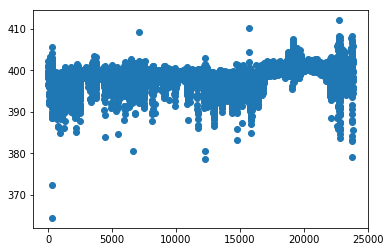

In [567]:
plt.scatter(df.index,df['co2ppm'])

In [568]:
aq.head()


Latitude   Longitude  Date Local   CO Mean  CO Max Value  CO Max Hour  \
0  37.814781 -122.282347  2015-01-01  0.708696           2.2           21   
1  37.814781 -122.282347  2015-01-01  0.708696           2.2           21   
2  37.814781 -122.282347  2015-01-01  0.708696           2.2           21   
3  37.814781 -122.282347  2015-01-01  0.708696           2.2           21   
4  37.814781 -122.282347  2015-01-01  0.533333           1.3           23   

    Oz Mean  Oz Max Value  Oz Max Hour   SO Mean  SO Max Value  SO Max Hour  \
0  0.015882         0.034            9  1.050000           1.5           16   
1  0.015882         0.034            9  1.050000           1.5           16   
2  0.015882         0.034            9  1.042857           1.4           23   
3  0.015882         0.034            9  1.042857           1.4           23   
4  0.015882         0.034            9  1.050000           1.5           16   

   Part Mean  Part Max Value  Part Max Hour  AQI  Category  \
0       13.0            35.0             21   61  Moderate   
1       13.0            13.0              0   61  Moderate   
2       13.0            35.0             21   61  Moderate   
3       13.0            13.0              0   61  Moderate   
4       13.0            35.0             21   61  Moderate   

  AQ Defining Parameter  
0                 PM2.5  
1                 PM2.5  
2                 PM2.5  
3                 PM2.5  
4                 PM2.5

In [ ]:
aq['latlong'] = [(x,y) for x,y in zip(list(aq['Latitude']), list(aq['Longitude']))]

In [592]:
plt.scatter(aq.index,aq['Part Mean'])

In [594]:
plt.scatter(aq.index,aq['CO Mean'])

In [799]:
          [(i,np.avg(aq[aq['Date Local']== x])) for x in aq['Date Local'].unique()]

Latitude   Longitude  Date Local   CO Mean  CO Max Value  CO Max Hour  \
72  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
73  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
74  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
75  37.814781 -122.282347  2015-01-10  0.565217           1.3            4   
76  37.814781 -122.282347  2015-01-10  0.579167           1.0            5   

     Oz Mean  Oz Max Value  Oz Max Hour   SO Mean  SO Max Value  SO Max Hour  \
72  0.008118         0.016            9  0.913636           2.4           15   
73  0.008118         0.016            9  0.913636           2.4           15   
74  0.008118         0.016            9  0.866667           1.4           14   
75  0.008118         0.016            9  0.866667           1.4           14   
76  0.008118         0.016            9  0.913636           2.4           15   

    Part Mean  Part Max Value  Part Max Hour  AQI  Category  \
72  17.458333            25.0              2   72  Moderate   
73  17.400000            17.4              0   72  Moderate   
74  17.458333            25.0              2   72  Moderate   
75  17.400000            17.4              0   72  Moderate   
76  17.458333            25.0              2   72  Moderate   

   AQ Defining Parameter  
72                 PM2.5  
73                 PM2.5  
74                 PM2.5  
75                 PM2.5  
76                 PM2.5

In [798]:
aq['CO Mean'].diff()

72            NaN
73       0.000000
74       0.000000
75       0.000000
76       0.013950
77       0.000000
78       0.000000
79       0.000000
80      -0.013950
81       0.000000
82       0.000000
83       0.000000
84       0.038950
85       0.000000
86       0.000000
87       0.000000
104      0.174094
105      0.000000
106      0.000000
107      0.000000
108      0.050906
109      0.000000
110      0.000000
111      0.000000
136     -0.376993
137      0.000000
138      0.000000
139      0.000000
140      0.026993
141      0.000000
           ...   
17326    0.000000
17327    0.000000
17328   -0.005797
17329    0.000000
17330    0.000000
17331    0.000000
17348    0.079710
17349    0.000000
17350    0.000000
17351    0.000000
17352   -0.013043
17353    0.000000
17354    0.000000
17355    0.000000
17356    0.026087
17357    0.000000
17358    0.000000
17359    0.000000
17360   -0.005254
17361    0.000000
17362    0.000000
17363    0.000000
17364    0.044384
17365    0.000000
17366    0

In [ ]:
#creating a function to find out if the data is stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', 'Lags Used', 'Observations USed'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
    rolmean = pd.rolling_mean(timeseries, window = 12)
    rolstd = rolling_std(timeseries, window=12)
    
    #Plotting the rolling statistics
    orig = plt.plot(timeseries, color='black' label='Original')
    mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False);
    

In [ ]:
#helper function to visualize 
import statsmodels.tsa.api as smt

def plots(data, lags= None):
    layout =abs (1,3)
    raw = plt.subplot2grid(layout, (0,0))
    acf = plt.subplot2grid(layout, (0,1))
    pacf = plt.subplot2grid(layout, (0,2))
    
    data.plot(ax=raw)
    smt.graphics.plot(data, lags=lags, ax =acf)
    smt.graphics.plot(data, lags=lags, ax =pacf)
    sns.despine()
    plt.tight_layout();

In [ ]:
plots(aq['CO Mean', lags =75)

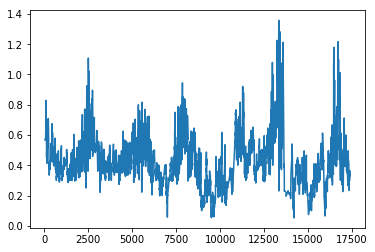

In [797]:

plt.plot(aq['CO Mean']);

# Distribution Prediction

Training a model to predict the distribution of other AQ factors in the air.  I will then cluster it all together in the next section, to find large (or larger) concentrations of the factors.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = aq[['Latitue', 'Longitude', 'CO Mean', 'SO Mean', 'Part Mean', 'Oz Mean']]
y = df[df['latlong'].isin(list(aq['latlong']))]['co2ppm']

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target)

# Clustering

Now that I am done with the EDA and data cleaning, I am goign to cluster the air quality data.

In [759]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score


In [761]:
clusterdf = aq[['CO Mean', 'SO Mean', 'Part Mean', 'Oz Mean']]

In [766]:
km.inertia_

2751.600271664947

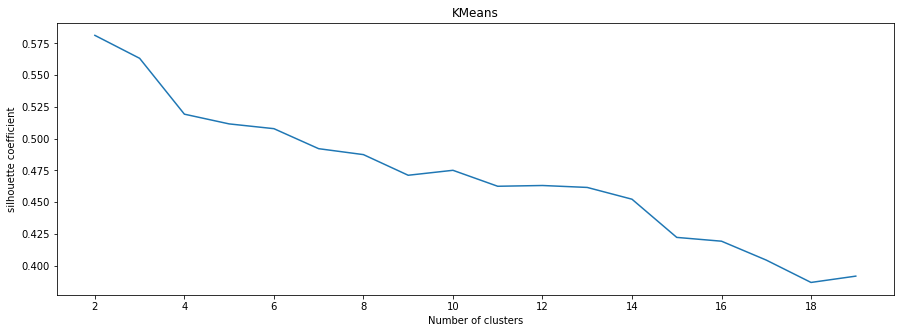

In [795]:
Sil_coefs = []
inertia = []
for k in range(2,20):
    km = KMeans(n_clusters = k)
    km.fit(clusterdf)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(clusterdf, labels, metric='euclidean'))
    inertia.append(km.inertia_)
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
#inertia says 4 clusters, silhouette is about .51
ax1.set_title('KMeans')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2));

In [783]:
km = KMeans(n_clusters = 4)
km.fit(clusterdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [784]:
mu_digits = km.cluster_centers_
kmlabels = km.labels_

In [787]:
print(len(kmlabels))
print(len(clusterdf))

11742
11742
